#   Answering Business Questions Using Chinook Database

## Introduction: 
 For this project we will be querying the chinook database to answer certain hypothetical business questions. The questions we will be answering are as follow:

*  In our first scenario,we will be trying to figure out the albums to add to our store from a number of artists whose music we don't have in our store. This decision will be guided by the genre that sells the most.
* We will try to evaluate the performance of our customer support agents using data from our database.
* Analyse sales data for each country.
* Compare album purchase to individual track purchases to figure out what sales strategy we can implement to drive revenue.
* The artist used the most in playlist.

Here's a schema diagram of the database below to give you information of the structure of our database.
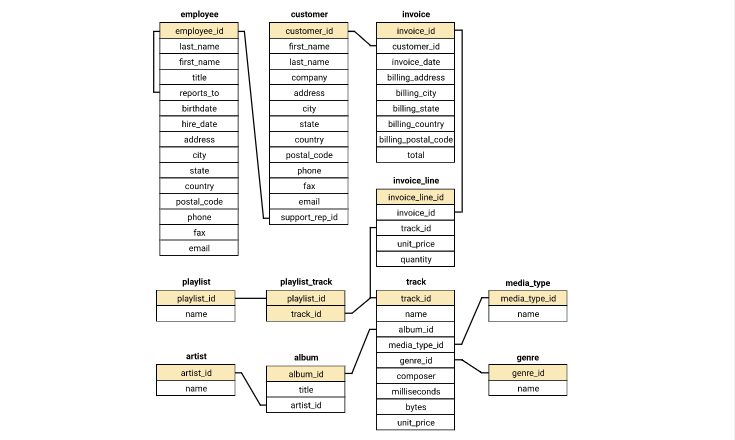






## Overview Of The Data

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

In [2]:
%%sql
SELECT
    name,
    type
  FROM sqlite_master
 WHERE type IN ("table","view");

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


In [3]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline


In [4]:
conn = sqlite3.connect('chinook.db')

 ## CASE 1: Selecting Albums To Add To The Store
 Here Chinbook has just signed a deal with a new record label that specialises with artist from the US and we are tasked with finding out the three albums out of four to add to our store. All of the four artists have no tracks in our store. We are going to find out the top selling genres in the US and use that to drive our decision on which three albums to add to the store. Below, we have the artist names and the genre of their albums.
 
 | Artist Name |	Genre |
|:---:|:---:|
| Regal |	Hip-Hop |
| Red Tone | Punk |
| Meteor and the Girls | Pop |
| Slim Jim Bites |	Blues |

In [5]:
query = """WITH us_records AS
     (SELECT 
            c.country,
            il.track_id
        FROM customer AS c
        LEFT JOIN invoice AS i
          ON i.customer_id = c.customer_id
        LEFT JOIN invoice_line AS il
          ON i.invoice_id = il.invoice_id
        WHERE country = 'USA'
     ),


us_genre_records AS   
    (SELECT 
          g.name AS genre,
          COUNT(*) AS tracks_sold

      FROM us_records AS ur
      LEFT JOIN track AS t
        ON t.track_id = ur.track_id
      LEFT JOIN genre AS g
        ON g.genre_id = t.genre_id
     GROUP BY genre
    )
    
SELECT
      *,
      ROUND(CAST(tracks_sold AS FLOAT) / (SELECT
                                                SUM(tracks_sold)
                                            FROM us_genre_records
                                           ), 3) AS perecntage_sold
  FROM us_genre_records 
 ORDER BY tracks_sold DESC 
 LIMIT 10;"""
cusor = conn.execute(query)
column_names = [description[0] for description in cusor.description] #gets the column names from our query.
top_genres = cusor.fetchall() #returns a list of tuples containing the data from our query.
genre_df= pd.DataFrame(top_genres, columns=column_names) #converts the our list to a pandas dataframe.
genre_df



,genre,tracks_sold,perecntage_sold
0,Rock,561,0.534
1,Alternative & Punk,130,0.124
2,Metal,124,0.118
3,R&B/Soul,53,0.050
4,Blues,36,0.034
5,Alternative,35,0.033
6,Latin,22,0.021
7,Pop,22,0.021
8,Hip Hop/Rap,20,0.019
9,Jazz,14,0.013


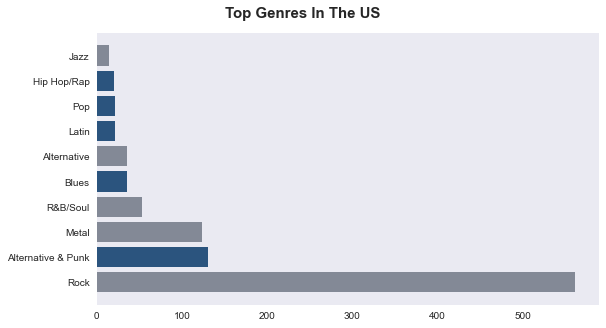

In [6]:
#plotting the data of the top genres in the US
style.use('seaborn')
fig, ax = plt.subplots(figsize=(9, 5))
ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)
# Allows up to map colors to specific bars on our bar plot
album_genre = (genre_df['tracks_sold'] == 130) | (genre_df['tracks_sold'] == 36)| (genre_df['tracks_sold'] == 22) | (genre_df['tracks_sold'] == 20)
genre_map = album_genre.map({True:'#2B547E', False:'#838996'})
ax.barh(genre_df['genre'], genre_df['tracks_sold'], color=genre_map)
ax.grid(b=False)
ax.text(x=150, y=10.5, s='Top Genres In The US', size=15, weight='bold')
plt.show()


From our plot we can see that from the four genre we have to pick from, Punk has sold the highest in the united states and has a market share of 12%, followed by Blues, Pop and just slightly behind Hip-Hop. Selecting an Album to have in our store, I think the Punk and Blues album are a must have and Then we can complete those with any of the Pop or Hip-Hop album as there isn't a significant difference in their market share.

## CASE 2: Employee Sales Performance:
The goal here is to find out which employee has performed the best and also to find out the underlying factor behind the employee's performance.

In [7]:
query2 = """WITH invoice_details AS 
        (SELECT *,
             SUM(il.quantity) AS total_quantity_sold
        FROM invoice_line AS il
        INNER JOIN invoice AS i  on il.invoice_id = i.invoice_id
        GROUP BY il.invoice_id
        ),
    
customer_invoice AS        
        (SELECT *,
                SUM(total) AS customer_total,
                SUM(total_quantity_sold) AS total_quantity_purchased
           FROM invoice_details AS iv
          INNER JOIN customer AS c
             ON c.customer_id = iv.customer_id 
          GROUP BY c.customer_id
        )
SELECT e.first_name || " " || e.last_name AS employee_name,
       e.title,
       e.hire_date,
       ROUND(SUM(ci.customer_total), 2) AS total_amount_sold,
       SUM(ci.total_quantity_purchased) AS total_quantity_sold
  FROM customer_invoice AS ci
 INNER JOIN employee AS e
    ON e.employee_id = ci.support_rep_id
 GROUP BY e.employee_id ;"""

cusor = conn.execute(query2)
column_names = [description[0] for description in cusor.description] #gets the column names from our query.
employees = cusor.fetchall() #returns a list of tuples containing the data from our query.
employee_df= pd.DataFrame(employees, columns=column_names) #converts the our list to a pandas dataframe.
employee_df
       
            

,employee_name,title,hire_date,total_amount_sold,total_quantity_sold
0,Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,1731.51,1749
1,Margaret Park,Sales Support Agent,2017-05-03 00:00:00,1584.00,1600
2,Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,1393.92,1408


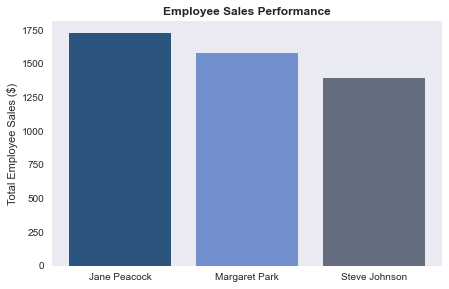

In [8]:
style.use('seaborn')
fig, ax  = plt.subplots(figsize=(7,4.5))
ax.bar(employee_df['employee_name'], employee_df['total_amount_sold'], color='#728fce')
#adding individual colos to the different bars representing the individual employees.
ax.bar(employee_df['employee_name'].iloc[0], employee_df['total_amount_sold'].iloc[0], color='#2b547e')
ax.bar(employee_df['employee_name'].iloc[2], employee_df['total_amount_sold'].iloc[2], color='#646d7e')
ax.tick_params(bottom=0, left=0)
ax.grid(False)
ax.set_ylabel('Total Employee Sales ($)')
ax.set_title('Employee Sales Performance', weight='bold', size=12)
plt.show()


The difference in sales between the different Sales Support Agent seems to correspond with the date they were hired. With the top sales agent being the agent hired the earliest. From our data, we can infer that the major factor behind an employee's sales performance is the time they have been at the company.

## CASE 3: Sales Value By Country:
We are going to find out the average sales value customers from the different countries as well as the average order value.
Note: countries that did not have more than 1 customer were grouped together as Others.

In [9]:
query3 = """WITH country_or_other AS 
     (SELECT
            CASE
            WHEN
                (SELECT
                       count(*)
                   FROM customer
                  WHERE country = c.country
                ) = 1
                   THEN 'Others'
                   ELSE c.country
                   END AS country,
                   c.customer_id,
                   il.*
        FROM customer AS c
       INNER JOIN invoice AS i
          ON i.customer_id = c.customer_id
       INNER JOIN invoice_line AS il
          ON il.invoice_id = i.invoice_id
     )
    
SELECT
      country,
      customers,
      total_sales,
      average_customer_value,
      average_order_value
  FROM (SELECT
              country,
              count(DISTINCT customer_id) AS customers,
              ROUND(SUM(unit_price), 2) AS total_sales,
              ROUND(SUM(unit_price) / COUNT(DISTINCT customer_id), 2) AS average_customer_value,
              ROUND(SUM(unit_price) / COUNT(DISTINCT invoice_id), 2) AS average_order_value,
              CASE
                  WHEN country = 'Others'
                  THEN 1
                  ELSE 0
                  END AS sort
         FROM country_or_other
        GROUP BY country
        ORDER BY sort, total_sales DESC
       ) ;"""
cusor = conn.execute(query3)
column_names = [description[0] for description in cusor.description] #gets the column names from our query.
country = cusor.fetchall() #returns a list of tuples containing the data from our query.
country_df= pd.DataFrame(country, columns=column_names) #converts the our list to a pandas dataframe.
country_df
       

,country,customers,total_sales,average_customer_value,average_order_value
0,USA,13,1040.49,80.04,7.94
1,Canada,8,535.59,66.95,7.05
2,Brazil,5,427.68,85.54,7.01
3,France,5,389.07,77.81,7.78
4,Germany,4,334.62,83.66,8.16
5,Czech Republic,2,273.24,136.62,9.11
6,United Kingdom,3,245.52,81.84,8.77
7,Portugal,2,185.13,92.57,6.38
8,India,2,183.15,91.58,8.72
9,Others,15,1094.94,73.00,7.45


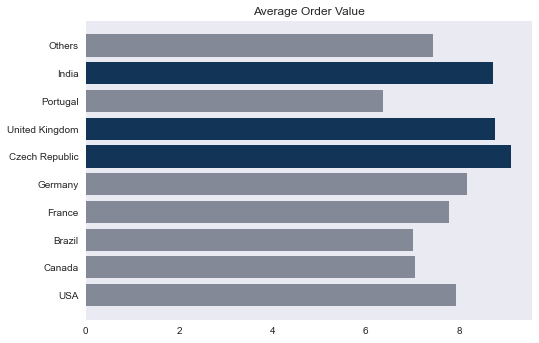

In [10]:
fig, ax = plt.subplots()
#maps the countries with the highest order values to a specific colour
top_avg_order = (country_df['average_order_value'] == 9.11) | (country_df['average_order_value'] == 8.77) | (country_df['average_order_value'] == 8.72)
order_map = top_avg_order.map({True:'#123456', False:'#838996'})
ax.barh(country_df['country'], country_df['average_order_value'], color = order_map)
ax.grid(False)
ax.set_title('Average Order Value')
plt.show()

Based on our data, we get the highest average order values in:
1. Czech Republic
2. United Kingdom
3. India.

These are potential markets to keep an eye on. Since our data is a small sample size, a large ad campaign will be careless and so we should experiment with small ad campaugns in those markets to see if the resulting customers follow the trend from our data. 

## CASE 4: Comparing Album Purchases to Tracks Purchase:
The management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

In [11]:
query4 = """WITH invoice_track_info AS
     (SELECT 
            invoice_id,
            MAX(track_id) AS track_id
        FROM invoice_line
       GROUP BY invoice_id
     )

SELECT 
     album_purchase,
     COUNT(invoice_id) AS invoices,
     ROUND(CAST(COUNT(invoice_id) AS FLOAT) / (SELECT COUNT(*)
             FROM invoice), 2) AS percent
  FROM (SELECT it.*,
               CASE
                   WHEN (SELECT
                               t.track_id
                           FROM track AS t
                          WHERE album_id = (
                          SELECT t2.album_id FROM track AS t2
                           WHERE t2.track_id = it.track_id
                          )
                              
                          EXCEPT
                              
                          SELECT il2.track_id 
                             FROM invoice_line AS il2
                            WHERE il2.invoice_id = it.invoice_id
                          
                        ) IS NULL
        
                    AND
                        (SELECT il2.track_id
                           FROM invoice_line AS il2
                          WHERE il2.invoice_id = it.invoice_id
                        
                 EXCEPT
                        SELECT t.track_id
                          FROM track AS t
                         WHERE t.album_id = (
                         SELECT t2.album_id FROM track AS t2
                          WHERE t2.track_id = it.track_id
                         )
                        ) IS NULL
                                
                         THEN 'Yes'
                         ELSE 'No'
                         END AS album_purchase
          FROM invoice_track_info AS it
       ) 
 GROUP BY album_purchase ;"""
                         
cusor = conn.execute(query4)
column_names = [description[0] for description in cusor.description] #gets the column names from our query.
album = cusor.fetchall() #returns a list of tuples containing the data from our query.
album_df= pd.DataFrame(album, columns=column_names) #converts the our list to a pandas dataframe.
album_df       
                          

,album_purchase,invoices,percent
0,No,500,0.81
1,Yes,114,0.19


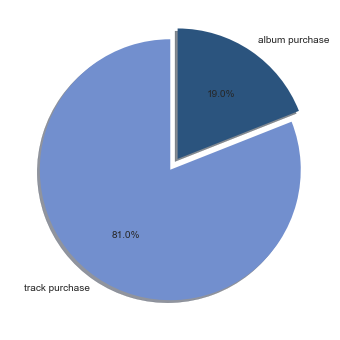

In [12]:
fig, ax = plt.subplots(figsize=(9, 6))
labels='track purchase', 'album purchase'
colors =['#728fce', '#2b547e']
ax.pie(album_df['percent'], explode=(0,0.1), labels=labels,
       autopct ='%1.1f%%',
       shadow=True, startangle=90, colors = colors )
plt.show()

19% of all purchases are album purchases. If we were to change strategies, only purchasing the  most popular tracks in an album from record label, we will be losing 19% of our income stream. The current strategy is good as it is.

## CASE 5: Most Frequent Artist In Playlists.

In [13]:
query5 = """SELECT
      a.name AS artist_name, 
      COUNT(pt.playlist_id) AS number_of_playlist
 FROM artist a
INNER JOIN album ab
   ON ab.artist_id  = a.artist_id
INNER JOIN track t
   ON ab.album_id = t.album_id
INNER JOIN playlist_track pt
   ON pt.track_id = t.track_id
GROUP BY a.name
ORDER BY number_of_playlist DESC
LIMIT 10 ;"""

cusor = conn.execute(query5)
column_names = [description[0] for description in cusor.description] #gets the column names from our query.
playlist = cusor.fetchall() #returns a list of tuples containing the data from our query.
playlist_df= pd.DataFrame(playlist, columns=column_names) #converts the our list to a pandas dataframe.
playlist_df 

,artist_name,number_of_playlist
0,Iron Maiden,516
1,U2,333
2,Metallica,296
3,Led Zeppelin,252
4,Deep Purple,226
5,Lost,184
6,Pearl Jam,177
7,Faith No More,145
8,Eric Clapton,145
9,Lenny Kravitz,143


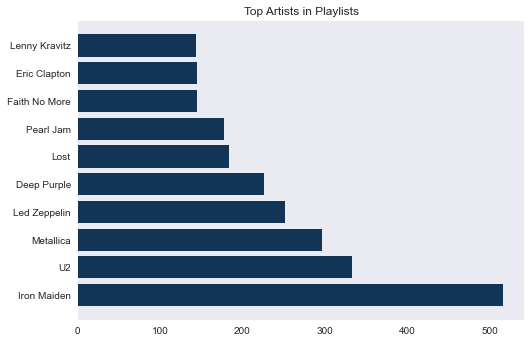

In [14]:
fig, ax = plt.subplots()
ax.barh(playlist_df['artist_name'], playlist_df['number_of_playlist'], color='#123456')
ax.grid(False)
ax.set_title('Top Artists in Playlists')
plt.show()

Our plot above shows us the 10 most common artists found in playlists of our customers. With the top 3 being Iron Maiden, U2 and Metallica.

In [15]:
conn.close()

## Conclusion:
Our goal was to answer certain hypothetical questions and so far we have been able to answer them. We have found out the following

1. The most popular genre of songs in the US and then used that to figure out which three albums to add to our store.
2. The highest performing sales agent and also the correlation between the sales performance and the date of hire.
3. The sales value of customers for individual countries as well as the order value.
4. We figured out the percentage of our sales revenue that comes from album sales and then used it to guide our decision on whether to purchase albums or just the most popular track from an album.
5. We found out the artists that are the most common in playlists.